# Graph cut idea demo

In [52]:
import random
import numpy as np
from numpy.linalg import norm as vector_norm
import matplotlib.pyplot as plt

In [53]:
import sys
sys.path.append('../modules')
from nsw.nsw import Node, NSWGraph

## Generate a simple dataset with smooth convex border

In [54]:
G = NSWGraph()

N = 2000
values = []
for i in range(N):
    p = np.array([random.random(), random.random()])
    cls = 1 if vector_norm(p) > 0.8 else 0
    values.append((p, cls))

        
G.build_navigable_graph(values, attempts=10)

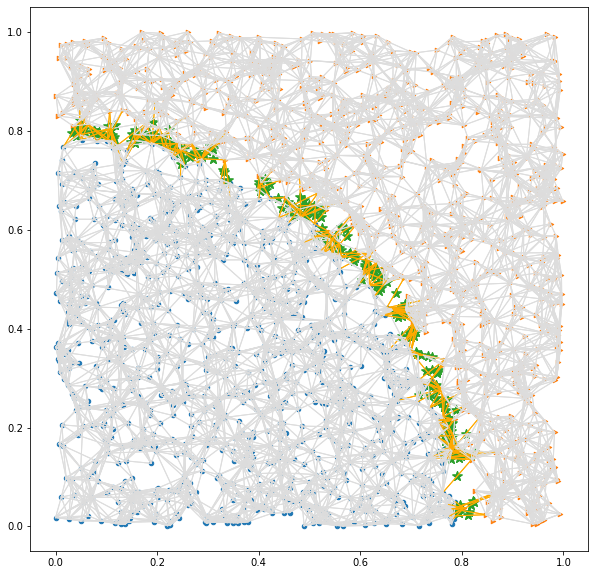

In [4]:
G.plot(.1)

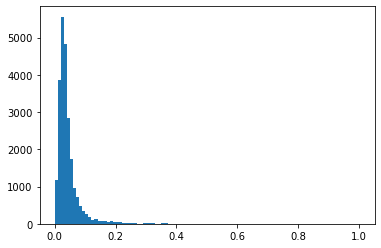

In [55]:
edges = [G.dist(G.nodes[e[0]].value, G.nodes[e[1]].value) for e in G.get_edges()]
plt.hist(edges, bins=100)
plt.show()

## Lognorm? No

Params shape = 0.6800, loc = -0.0018, scale = 0.0355
E = 0.024132437677758377
Median 0.034


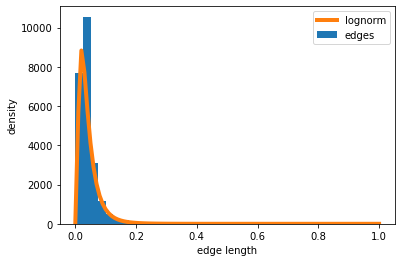

In [56]:
from  scipy.stats import lognorm, kstest
shape, loc, scale = lognorm.fit(edges)
print(f"Params shape = {shape:.4f}, loc = {loc:.4f}, scale = {scale:.4f}")
expected_value = shape * scale
print("E =", expected_value) # edge length
median = lognorm.median(shape, loc, scale)
print(f"Median {median:.3f}")
plt.xlabel("edge length")
plt.ylabel("density")
plt.hist(edges, bins=40, label="edges")
x = np.linspace(0, 1, 101)
L = [lognorm.pdf(v, shape, loc, scale) * sum(edges) / 2.5 for v in x]
plt.plot(x, L, linewidth=4, label="lognorm")
plt.legend()
plt.show()

We expect `statistics` close to 0, and `p-value` close to 1 to be able not to reject Null-hypothesis (data comes from lognorm distribuition).

In [59]:
from scipy.stats import chisquare

samples = [lognorm.rvs(shape, loc, scale) for _ in range(10000)]

sample_bins, e = np.histogram(samples, range=(0.001, 1), bins=20)
edges_bins, e = np.histogram(edges, range=(0.001, 1), bins=20)

print("This is what happens when we run for a sample from the distribuition")
print(kstest(samples, "lognorm", lognorm.fit(samples)))

This is what happens when we run for a sample from the distribuition
KstestResult(statistic=0.005736810818658233, pvalue=0.8951595909090707)


We want the probability of rejecting a true null hypothesis to be $\alpha$ (e.g. high).
We reject when the observed `p-value` < $\alpha$.

In [60]:
kstest(edges, "lognorm", lognorm.fit(edges))

KstestResult(statistic=0.04998468234281905, pvalue=1.8444145847041875e-52)

Thus, this is definitely not lognormal with `p-value` << any.

# By nature this distribuition can be close to Chi with k = dims


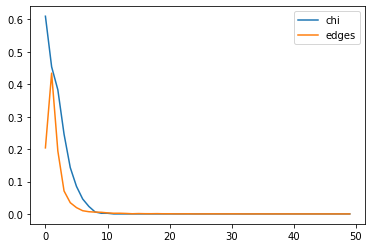

KstestResult(statistic=0.9651619386283921, pvalue=0.0)
Power_divergenceResult(statistic=320440.8748728469, pvalue=0.0)


In [83]:
from scipy.stats import chi

k = 2
params = chi.fit(edges, k)
samples = [chi.rvs(*params, k) for _ in range(1000)]

sample_bins, e = np.histogram(samples, range=(0.00001, 1), bins=50)
edges_bins, e = np.histogram(edges, range=(0.00001, 1), bins=50)

plt.plot(sample_bins / len(samples), label="chi")
plt.plot(edges_bins / len(edges), label="edges")
plt.legend()
plt.show()
t = kstest(edges, lambda x: chi.cdf(x, df=k))
print(t)
print(chisquare(edges_bins[:10], f_exp=sample_bins[:10]))

# TODO: find a proper distribution. For now we will stick to gamma assuming this is changeable

In [84]:
distribution = chi

Median: 0.038, True: 0.032783132529516756


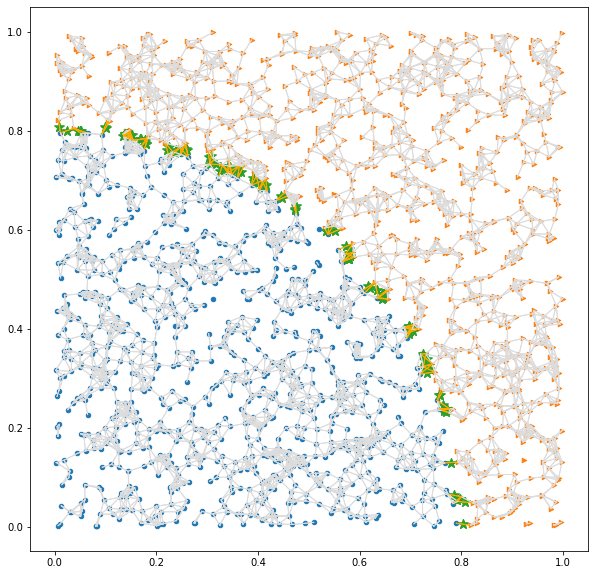

In [85]:
params = distribution.fit(edges, 2)
median = distribution.median(*params)
# half of the edges fall under this threshold!
print(f"Median: {median:.3f}, True: {sorted(edges)[len(edges) // 2]}")
G.plot(sorted(edges)[len(edges) // 2])

# How dimensions influence distribution

Dimensions: 2
Params: (0.8047796733394657, 0.0002351109081004046, 0.06963344041679495)
1.0259010132060484


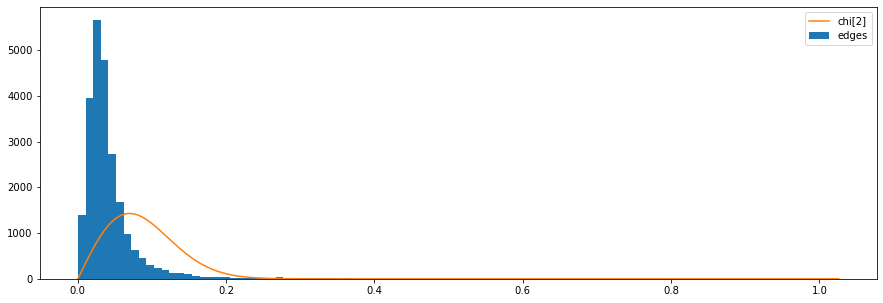

KstestResult(statistic=0.536295237483661, pvalue=0.0)
Dimensions: 4
Params: (2.785128997616622, 0.016824703164285075, 0.13699918133966943)
1.2196411832191105


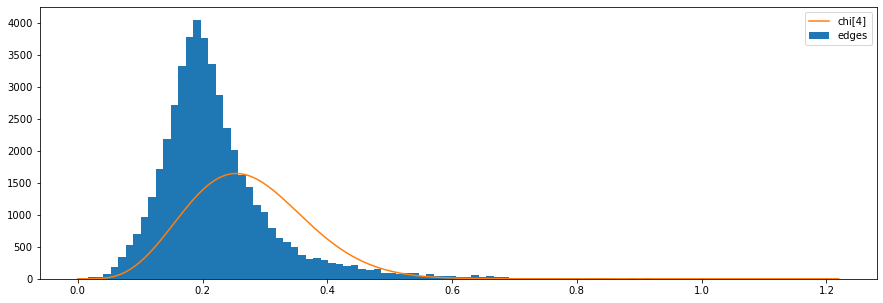

KstestResult(statistic=0.31275427789565025, pvalue=0.0)
Dimensions: 8
Params: (5.736274149520989, 0.1401339425269134, 0.2025333784356209)
1.7817909253701631


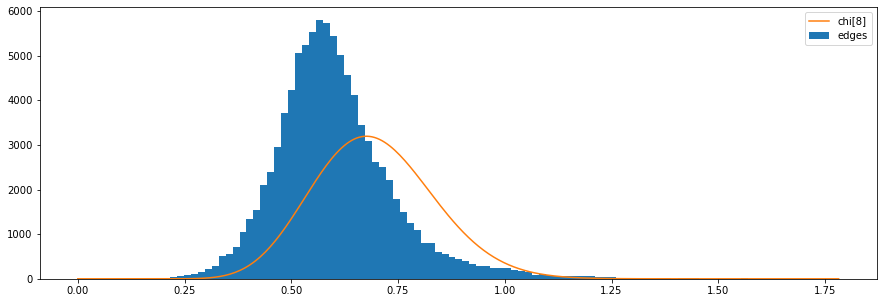

KstestResult(statistic=0.31396633924583484, pvalue=0.0)
Dimensions: 16
Params: (9.594712995615648, 0.45419660300873926, 0.2339656771234644)
2.4263548950266105


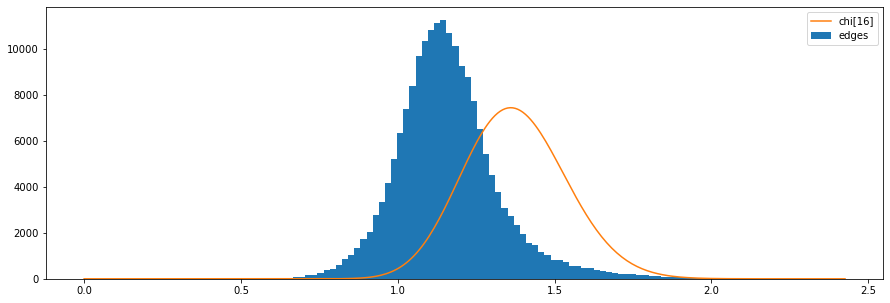

KstestResult(statistic=0.5415543636622115, pvalue=0.0)
Dimensions: 32
Params: (11.477013079641967, 1.0850888485643844, 0.25328576218126325)
3.1608896727810887


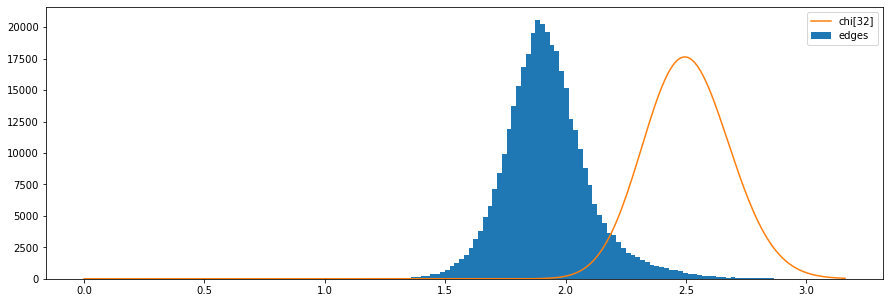

KstestResult(statistic=0.8955868047656018, pvalue=0.0)
Dimensions: 64
Params: (18.58536768061147, 1.8326287873502847, 0.26581492763309833)
4.16431036958428


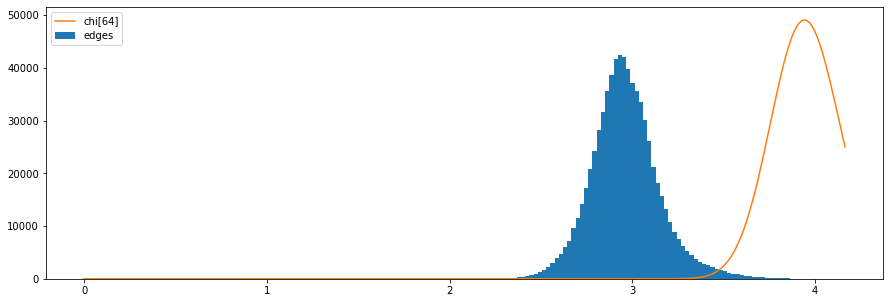

KstestResult(statistic=0.9826450604234725, pvalue=0.0)
Dimensions: 128
Params: (46.63417885927444, 2.5225440262689576, 0.27688471459604824)
5.670094151248185


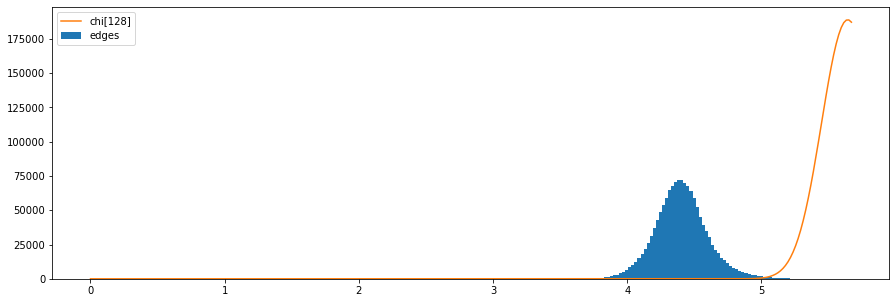

KstestResult(statistic=0.9962266065937857, pvalue=0.0)
Dimensions: 256
Params: (162.0373593402744, 2.6841419098977113, 0.2941847936549249)
7.585716440832901


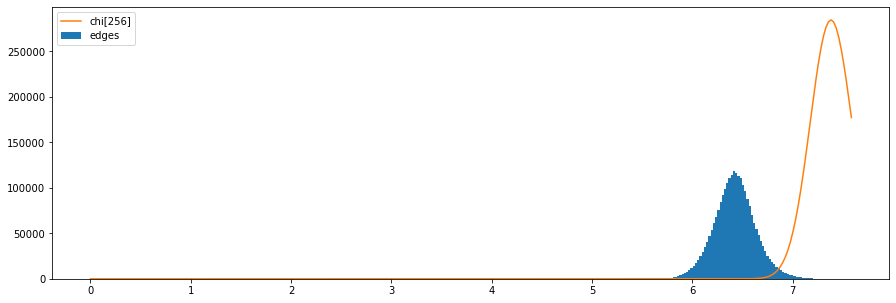

KstestResult(statistic=0.9751211724990166, pvalue=0.0)


In [116]:
dims = [2, 4, 8, 16, 32, 64, 128, 256]
N = 2000

for dim in dims:
    G = NSWGraph()
    values = []
    print(f"Dimensions: {dim}")
    for i in range(N):
        p = np.array([random.random() for _ in range(dim)])
        cls = 1 if vector_norm(p) > .79 * (dim / 2) ** .5 else 0
        values.append((p, cls))

    G.build_navigable_graph(values, attempts=10)
    

    the_edges = [G.dist(G.nodes[e[0]].value, G.nodes[e[1]].value) for e in G.get_edges()]
    params = distribution.fit(the_edges, dim)
    _, loc, scale = params
    print(f"Params: {params}")    
    plt.figure(figsize=(15, 5))
    plt.hist(the_edges, bins=100, label="edges")
    print(max(the_edges))
    x = np.linspace(0.0, max(the_edges), 301)
    y = np.array([chi.pdf(i, dim, loc=loc, scale=scale) for i in x])
    y /= sum(y)
    y *= len(the_edges) * 2
    # print(y)
    plt.plot(x, y, label=f"chi[{dim}]")
    plt.legend()
    plt.show()
    print(kstest(the_edges, lambda x: chi.cdf(x, dim, loc=loc, scale=scale)))    